# 631 Project

install pyspark and load data from kaggle

In [ ]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
!tar xf spark-3.3.3-bin-hadoop3.tgz
!pip install -q findspark
!wget -q https://student.cs.uwaterloo.ca/~cs451/content/cs431/sql-data.tgz
!tar -xzf sql-data.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

import findspark
findspark.init()

from pyspark.sql import SparkSession
import random

spark = SparkSession.builder.master("local[*]").appName("Colab").getOrCreate()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d robikscube/flight-delay-dataset-20182022

100% 3.73G/3.73G [00:49<00:00, 136MB/s]
100% 3.73G/3.73G [00:49<00:00, 80.3MB/s]


In [ ]:
! unzip /content/flight-delay-dataset-20182022.zip

Archive:  /content/flight-delay-dataset-20182022.zip
  inflating: Airlines.csv            
  inflating: Combined_Flights_2018.csv  
  inflating: Combined_Flights_2018.parquet  
  inflating: Combined_Flights_2019.csv  
  inflating: Combined_Flights_2019.parquet  
  inflating: Combined_Flights_2020.csv  
  inflating: Combined_Flights_2020.parquet  
  inflating: Combined_Flights_2021.csv  
  inflating: Combined_Flights_2021.parquet  
  inflating: Combined_Flights_2022.csv  
  inflating: Combined_Flights_2022.parquet  
  inflating: raw/Flights_2018_1.csv  
  inflating: raw/Flights_2018_10.csv  
  inflating: raw/Flights_2018_11.csv  
  inflating: raw/Flights_2018_12.csv  
  inflating: raw/Flights_2018_2.csv  
  inflating: raw/Flights_2018_3.csv  
  inflating: raw/Flights_2018_4.csv  
  inflating: raw/Flights_2018_5.csv  
  inflating: raw/Flights_2018_6.csv  
  inflating: raw/Flights_2018_7.csv  
  inflating: raw/Flights_2018_8.csv  
  inflating: raw/Flights_2018_9.csv  
  inflating: raw/Fli

In [ ]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

In [ ]:
cf2018 = spark.read.csv('/content/Combined_Flights_2018.csv', header=True, sep=",")
cf2019 = spark.read.csv('/content/Combined_Flights_2019.csv', header=True, sep=",")
cf2020 = spark.read.csv('/content/Combined_Flights_2020.csv', header=True, sep=",")
cf2021 = spark.read.csv('/content/Combined_Flights_2021.csv', header=True, sep=",")
cf2022 = spark.read.csv('/content/Combined_Flights_2022.csv', header=True, sep=",")

cleaning data: since we have enough data for training, we would like to remove all rows with null

In [ ]:
cf2018.show(6)

+----------+-----------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|          Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrD

In [ ]:
cf2018 = cf2018.dropna()
cf2018.show(6)

+----------+-----------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|          Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrD

In [ ]:
cf2019 = cf2019.dropna()
cf2020 = cf2020.dropna()
cf2021 = cf2021.dropna()
cf2022 = cf2022.dropna()

Then, we want to do some visualization for better understanding the dataset

In [ ]:
import pyspark.sql.functions as f
import seaborn as sns
import matplotlib.pyplot as plt

1. Daily departure delay

In [ ]:
def daily_dep_delay(df, year):
  delay = df.select("FlightDate", "DepDelay").withColumn("FlightDate", f.col("FlightDate").cast("date"))
  delay = delay.withColumn("Month", f.month(f.col("FlightDate")))

  fig, axs = plt.subplots(3, 4, figsize=(12, 8))
  fig.suptitle(f'Average Daily Departure Delay for Year {year}', fontsize=14)
  for month_val in range(1, 13):
    #Filter data for the specific month
    monthly_data = delay.filter(f.col("Month") == month_val)

    #Group by day of the month and calculate the average delay
    daily_delay = monthly_data.groupBy(f.dayofmonth("FlightDate").alias("DayOfMonth"))\
                              .agg(f.avg("DepDelay").alias("AvgDelay"))\
                              .orderBy("DayOfMonth")
    #Covert to Pandas for plotting
    daily_delay_data = daily_delay.toPandas()
    ax = axs[(month_val-1) // 4, (month_val-1) % 4]
    daily_delay_data.plot(x='DayOfMonth', y='AvgDelay', marker='o', linestyle='-', ax=ax, legend=False)
    ax.set_ylim(-5, 35)
    ax.set_title(f'Month {month_val}', fontsize=10)
    ax.set_xlabel('Day of Month', fontsize=8)
    ax.set_ylabel('Avg Delay (Min)', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)

  plt.tight_layout(pad=2.0, h_pad=1.0, w_pad=1.0, rect=[0, 0.03, 1, 0.95])
  plt.show()

Plot for Year 2018

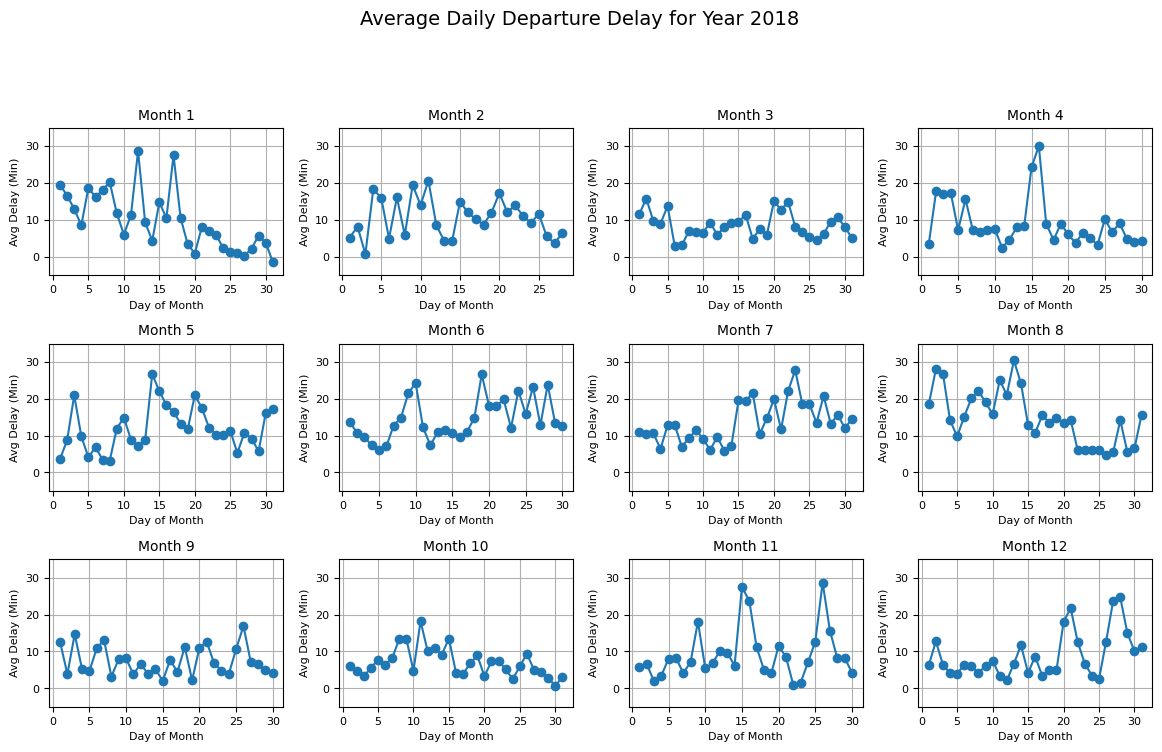

In [ ]:
daily_dep_delay(cf2018, 2018)

Plot for Year 2019

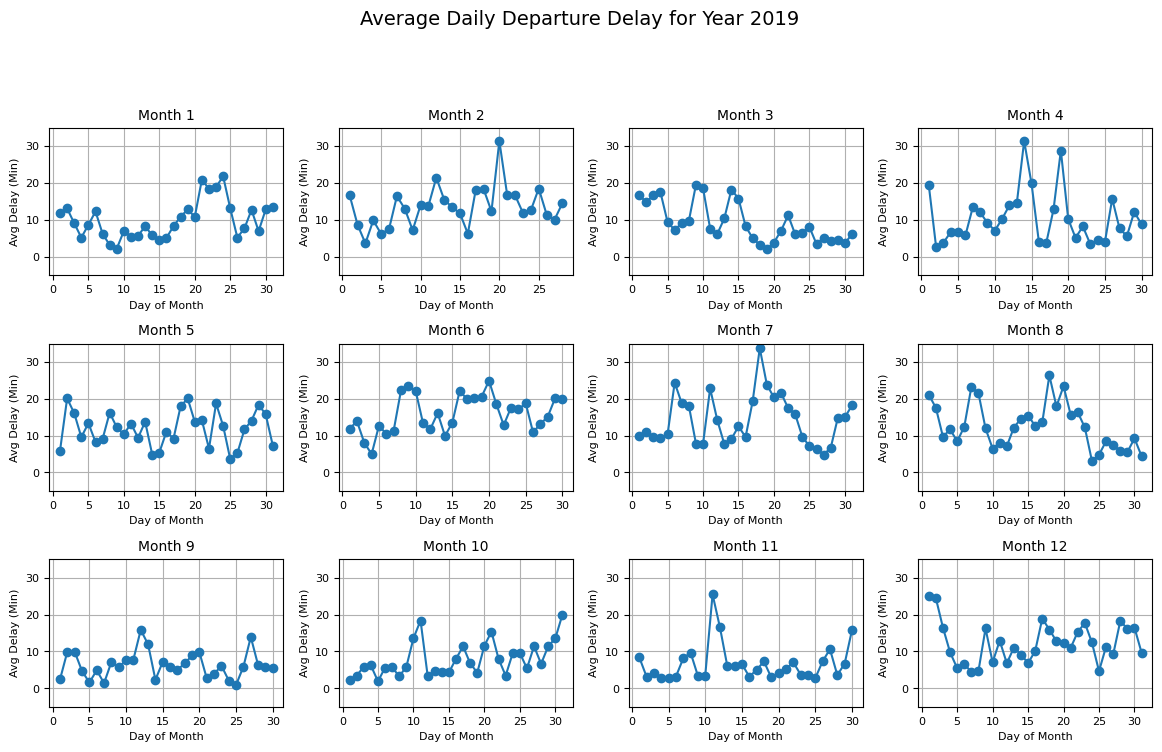

In [ ]:
daily_dep_delay(cf2019, 2019)

Plot for Year 2020

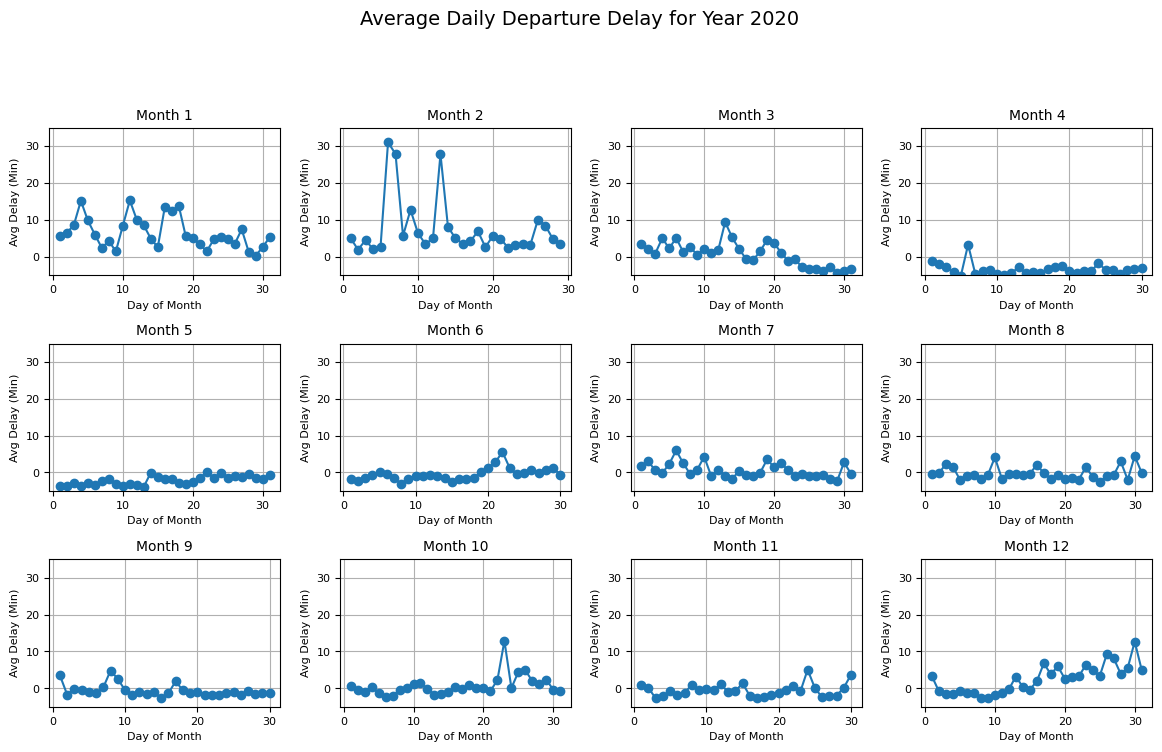

In [ ]:
daily_dep_delay(cf2020, 2020)

Plot for Year 2021

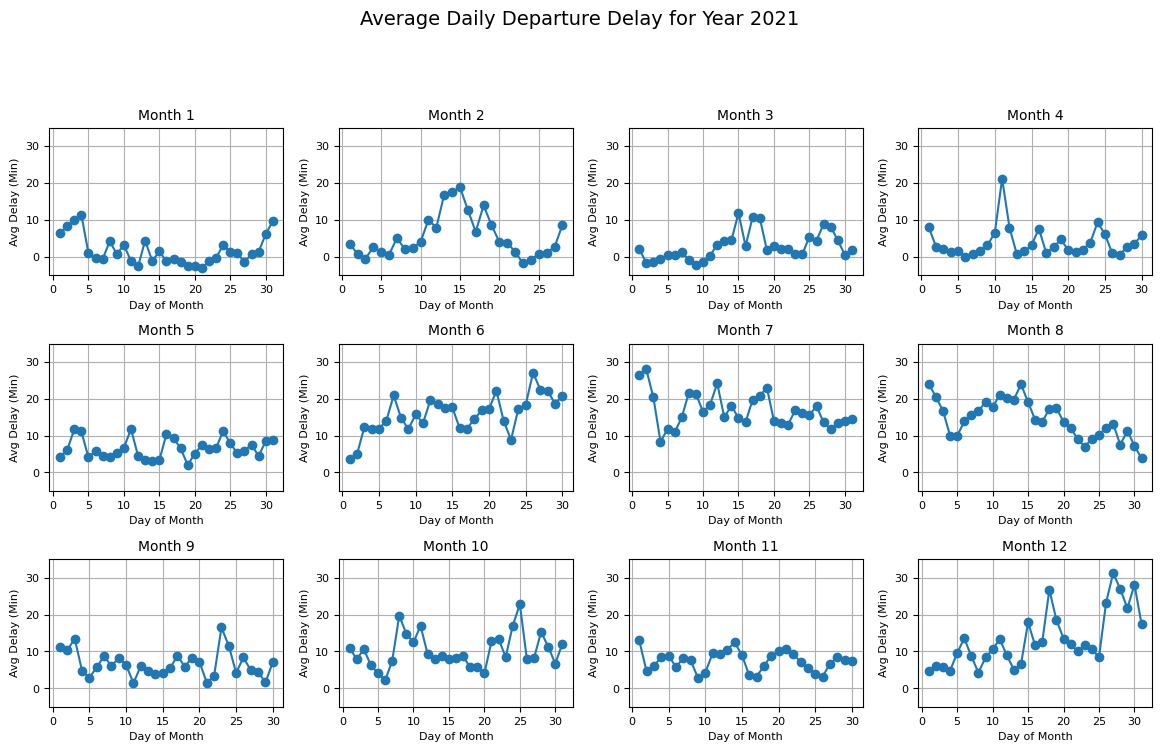

In [ ]:
daily_dep_delay(cf2021, 2021)

Plot for Year 2022

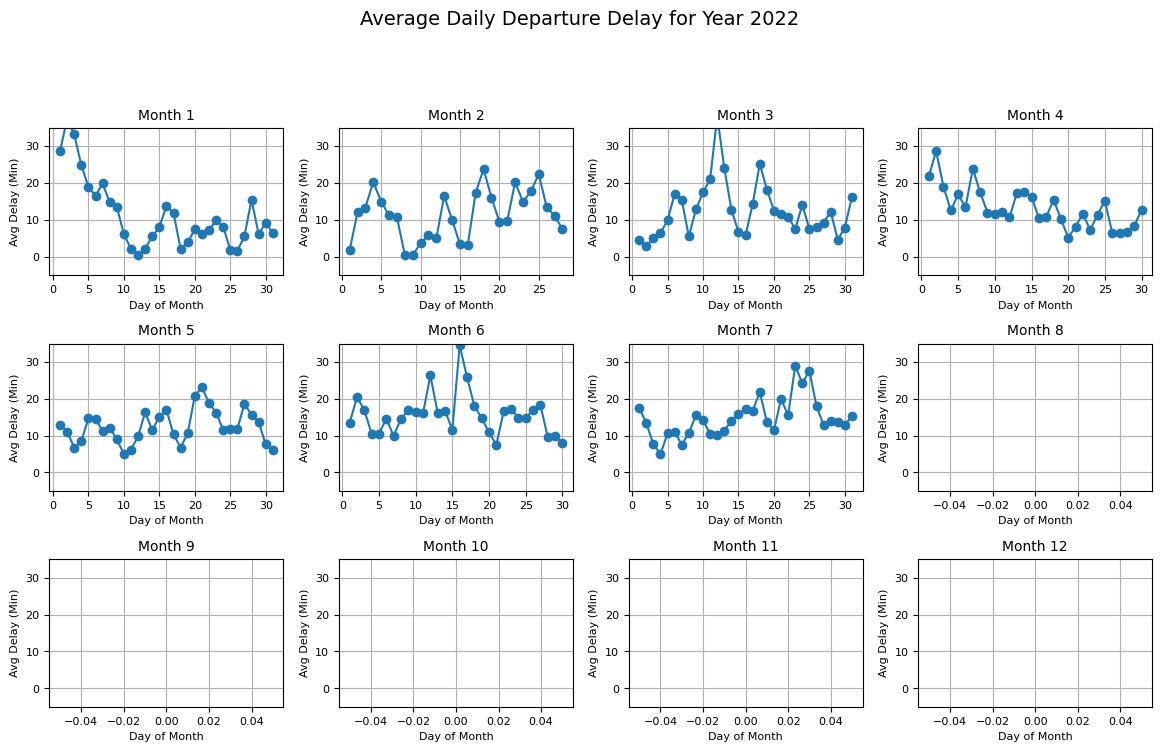

In [ ]:
daily_dep_delay(cf2022, 2022)

2. Heatmap of Delays by Day of Week and Time of Day

In [ ]:
def heatmap_plot(df, year):
  heatmap_df=df.select("FlightDate", "CRSDepTime", "DepDelay")
  #Convert CRSDepTime with 3 digits to 4 digits to extract hour information
  heatmap_df = heatmap_df.withColumn("CRSDepTime", f.col("CRSDepTime").cast("string"))
  heatmap_df = heatmap_df.withColumn("CRSDepTime", f.format_string("%04d", f.col("CRSDepTime").cast("int")))

  #Extract the hours
  heatmap_df = heatmap_df.withColumn("HourOfDay", f.expr("substring(CRSDepTime, 1, length(CRSDepTime)-2)").cast("int"))
  heatmap_df = heatmap_df.withColumn("DayOfWeek", f.dayofweek("FlightDate"))

  #Group by DayOfWeek and HourOfDay and calculate the average delay
  avgdelay = heatmap_df.groupBy("DayOfWeek", "HourOfDay")\
                        .agg(f.avg("DepDelay").alias("AvgDelay"))\
                        .orderBy("DayOfWeek", "HourOfDay")

  #Convert to pandas
  heatmap = avgdelay.toPandas()
  heatmap_matrix = heatmap.pivot("DayOfWeek", "HourOfDay", "AvgDelay")

  #Create the heatmap using seaborn
  plt.figure(figsize=(12, 6))
  sns.heatmap(heatmap_matrix, annot=True, fmt=".1f", linewidths=.5, cmap="YlGnBu", vmin=0, vmax=35)
  plt.title(f'Heatmap of Average Flight Delays by Day of Week and Time of Day, {year}')
  plt.xlabel('Hour of Day')
  plt.ylabel('Day of Week')
  plt.yticks(rotation=0)
  plt.show()

Plot for Year 2018

<ipython-input-32-f61b4262fb8a>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_matrix = heatmap.pivot("DayOfWeek", "HourOfDay", "AvgDelay")


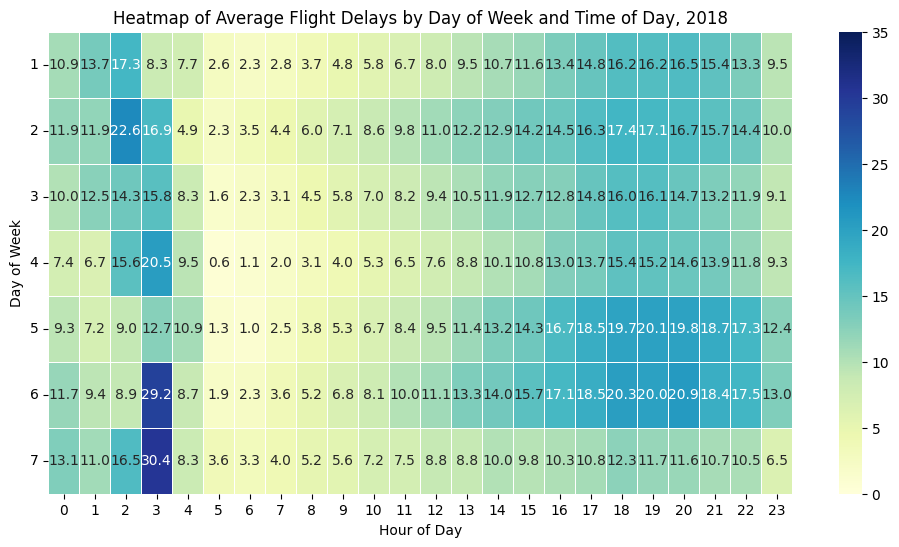

In [ ]:
heatmap_plot(cf2018, 2018)

Plot for Year 2019

<ipython-input-32-f61b4262fb8a>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_matrix = heatmap.pivot("DayOfWeek", "HourOfDay", "AvgDelay")


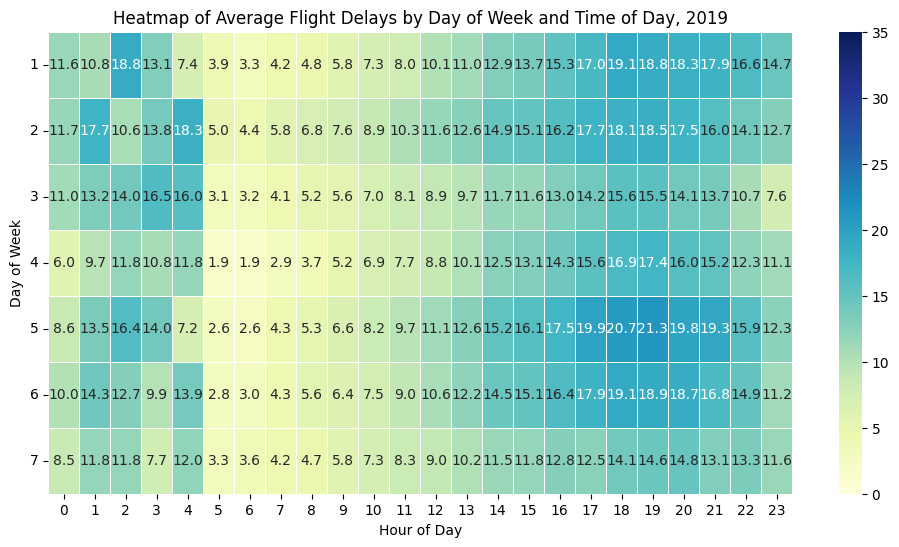

In [ ]:
heatmap_plot(cf2019, 2019)

Plot for Year 2020

<ipython-input-32-f61b4262fb8a>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_matrix = heatmap.pivot("DayOfWeek", "HourOfDay", "AvgDelay")


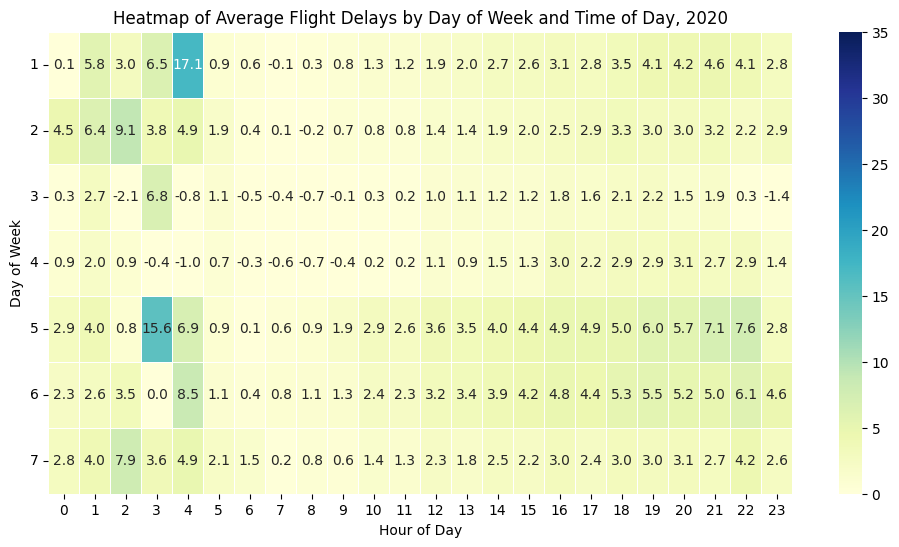

In [ ]:
heatmap_plot(cf2020, 2020)

Plot for Year 2021

<ipython-input-32-f61b4262fb8a>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_matrix = heatmap.pivot("DayOfWeek", "HourOfDay", "AvgDelay")


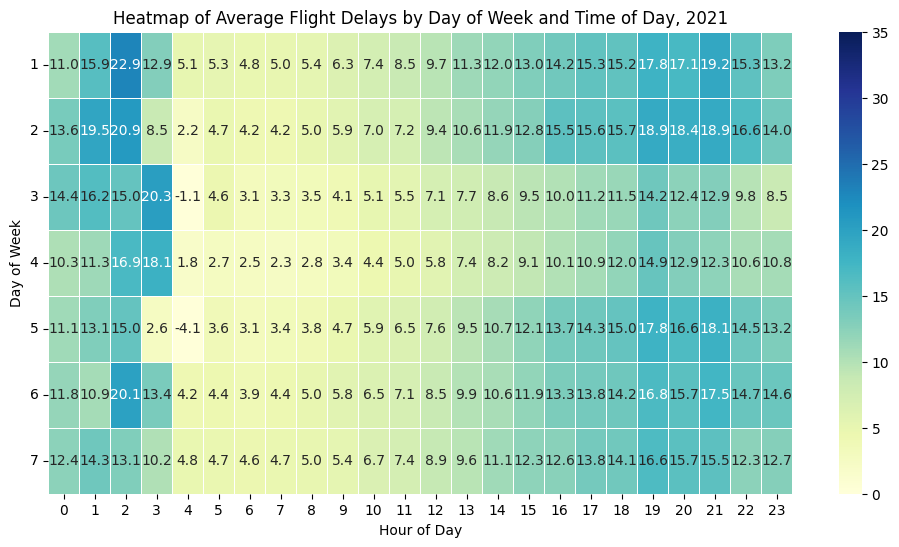

In [ ]:
heatmap_plot(cf2021, 2021)

Plot for Year 2022

<ipython-input-32-f61b4262fb8a>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_matrix = heatmap.pivot("DayOfWeek", "HourOfDay", "AvgDelay")


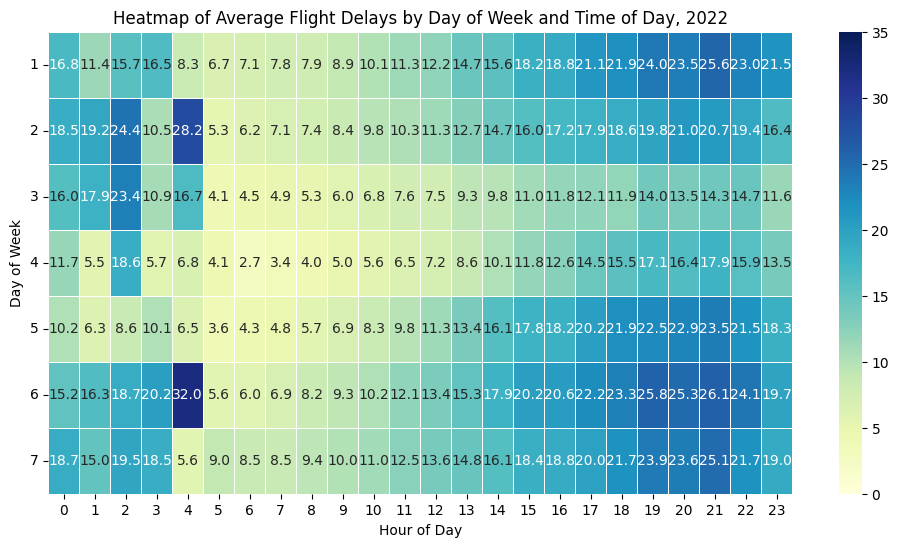

In [ ]:
heatmap_plot(cf2022, 2022)

We want to remove some cols since they have same meaning

In [ ]:
cols = [
    "Airline",
    "Cancelled",
    "Diverted",
    "DepTime",
    "DepDelay",
    "ArrTime",
    "ArrDelay",
    "AirTime",
    "Distance",
    "Month",
    "DayOfWeek",
    "Flight_Number_Operating_Airline",
    "OriginAirportID",
    "DestAirportID",
    "DepDel15",
    "TaxiOut",
    "WheelsOff",
    "WheelsOn",
    "TaxiIn",
    "ArrDel15",
    "DivAirportLandings"
]

In [ ]:
cf2018 = cf2018.select(cols)
cf2019 = cf2019.select(cols)
cf2020 = cf2020.select(cols)
cf2021 = cf2021.select(cols)
cf2022 = cf2022.select(cols)

In [ ]:
cf2018.show(6)

+-----------------+---------+--------+-------+--------+-------+--------+-------+--------+-----+---------+-------------------------------+---------------+-------------+--------+-------+---------+--------+------+--------+------------------+
|          Airline|Cancelled|Diverted|DepTime|DepDelay|ArrTime|ArrDelay|AirTime|Distance|Month|DayOfWeek|Flight_Number_Operating_Airline|OriginAirportID|DestAirportID|DepDel15|TaxiOut|WheelsOff|WheelsOn|TaxiIn|ArrDel15|DivAirportLandings|
+-----------------+---------+--------+-------+--------+-------+--------+-------+--------+-----+---------+-------------------------------+---------------+-------------+--------+-------+---------+--------+------+--------+------------------+
|Endeavor Air Inc.|    False|   False| 1157.0|    -5.0| 1256.0|    -8.0|   38.0|   145.0|    1|        2|                           3298|          10146|        10397|     0.0|   14.0|   1211.0|  1249.0|   7.0|     0.0|               0.0|
|Endeavor Air Inc.|    False|   False| 1157.

create index for Airlines

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Airline", outputCol="AirlineIndex")
cf2018 = indexer.fit(cf2018).transform(cf2018)
cf2019 = indexer.fit(cf2019).transform(cf2019)
cf2020 = indexer.fit(cf2020).transform(cf2020)
cf2021 = indexer.fit(cf2021).transform(cf2021)
cf2022 = indexer.fit(cf2022).transform(cf2022)


In [ ]:
cf2018.show(6)

+-----------------+---------+--------+-------+--------+-------+--------+-------+--------+-----+---------+-------------------------------+---------------+-------------+--------+-------+---------+--------+------+--------+------------------+------------+
|          Airline|Cancelled|Diverted|DepTime|DepDelay|ArrTime|ArrDelay|AirTime|Distance|Month|DayOfWeek|Flight_Number_Operating_Airline|OriginAirportID|DestAirportID|DepDel15|TaxiOut|WheelsOff|WheelsOn|TaxiIn|ArrDel15|DivAirportLandings|AirlineIndex|
+-----------------+---------+--------+-------+--------+-------+--------+-------+--------+-----+---------+-------------------------------+---------------+-------------+--------+-------+---------+--------+------+--------+------------------+------------+
|Endeavor Air Inc.|    False|   False| 1157.0|    -5.0| 1256.0|    -8.0|   38.0|   145.0|    1|        2|                           3298|          10146|        10397|     0.0|   14.0|   1211.0|  1249.0|   7.0|     0.0|               0.0|      

proceed some of the cols

In [ ]:
from pyspark.sql.functions import when
from pyspark.sql.functions import col, regexp_replace

cf2018 = cf2018.withColumn("Cancelled", when(cf2018["Cancelled"] == "True", 1).otherwise(0))\
    .withColumn("Diverted", when(cf2018["Diverted"] == "True", 1).otherwise(0))\
    .withColumn("AirlineIndex", col("AirlineIndex")+1)\


cf2019 = cf2019.withColumn("Cancelled", when(cf2019["Cancelled"] == "True", 1).otherwise(0))\
    .withColumn("Diverted", when(cf2019["Diverted"] == "True", 1).otherwise(0))\
    .withColumn("AirlineIndex", col("AirlineIndex")+1)\


cf2020 = cf2020.withColumn("Cancelled", when(cf2020["Cancelled"] == "True", 1).otherwise(0))\
    .withColumn("Diverted", when(cf2020["Diverted"] == "True", 1).otherwise(0))\
    .withColumn("AirlineIndex", col("AirlineIndex")+1)\


cf2021 = cf2021.withColumn("Cancelled", when(cf2021["Cancelled"] == "True", 1).otherwise(0))\
    .withColumn("Diverted", when(cf2021["Diverted"] == "True", 1).otherwise(0))\
    .withColumn("AirlineIndex", col("AirlineIndex")+1)\


cf2022 = cf2022.withColumn("Cancelled", when(cf2022["Cancelled"] == "True", 1).otherwise(0))\
    .withColumn("Diverted", when(cf2022["Diverted"] == "True", 1).otherwise(0))\
    .withColumn("AirlineIndex", col("AirlineIndex")+1)\

cf2018.show()

+-----------------+---------+--------+-------+--------+-------+--------+-------+--------+-----+---------+-------------------------------+---------------+-------------+--------+-------+---------+--------+------+--------+------------------+------------+
|          Airline|Cancelled|Diverted|DepTime|DepDelay|ArrTime|ArrDelay|AirTime|Distance|Month|DayOfWeek|Flight_Number_Operating_Airline|OriginAirportID|DestAirportID|DepDel15|TaxiOut|WheelsOff|WheelsOn|TaxiIn|ArrDel15|DivAirportLandings|AirlineIndex|
+-----------------+---------+--------+-------+--------+-------+--------+-------+--------+-----+---------+-------------------------------+---------------+-------------+--------+-------+---------+--------+------+--------+------------------+------------+
|Endeavor Air Inc.|        0|       0| 1157.0|    -5.0| 1256.0|    -8.0|   38.0|   145.0|    1|        2|                           3298|          10146|        10397|     0.0|   14.0|   1211.0|  1249.0|   7.0|     0.0|               0.0|      

We combine the dataframes

In [ ]:
from pyspark.sql.functions import rand
from pyspark.ml.feature import VectorAssembler
cfall = cf2018.union(cf2019).union(cf2020).union(cf2021).union(cf2022).drop("Airline")
cfall.printSchema()

root
 |-- Cancelled: integer (nullable = false)
 |-- Diverted: integer (nullable = false)
 |-- DepTime: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Flight_Number_Operating_Airline: string (nullable = true)
 |-- OriginAirportID: string (nullable = true)
 |-- DestAirportID: string (nullable = true)
 |-- DepDel15: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- WheelsOff: string (nullable = true)
 |-- WheelsOn: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- ArrDel15: string (nullable = true)
 |-- DivAirportLandings: string (nullable = true)
 |-- AirlineIndex: double (nullable = false)



In [ ]:
from pyspark.sql.types import IntegerType, DoubleType
columns_to_int = ["DepTime", "DepDelay", "ArrTime", "ArrDelay", "AirTime", "Distance",
           "Month", "DayOfWeek", "Flight_Number_Operating_Airline",
          "OriginAirportID", "DestAirportID", "DepDel15", "TaxiOut",
          "WheelsOff", "WheelsOn", "TaxiIn", "ArrDel15", "DivAirportLandings"]


for column in columns_to_int:
  cfall = cfall.withColumn(column, col(column).cast(DoubleType()))

In [ ]:
cfall.printSchema()

root
 |-- Cancelled: integer (nullable = false)
 |-- Diverted: integer (nullable = false)
 |-- DepTime: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Month: double (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- Flight_Number_Operating_Airline: double (nullable = true)
 |-- OriginAirportID: double (nullable = true)
 |-- DestAirportID: double (nullable = true)
 |-- DepDel15: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- WheelsOff: double (nullable = true)
 |-- WheelsOn: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- ArrDel15: double (nullable = true)
 |-- DivAirportLandings: double (nullable = true)
 |-- AirlineIndex: double (nullable = false)



In [ ]:
feature_columns = cfall.columns
feature_columns.remove('ArrDel15')
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
cf_assembled = assembler.transform(cfall)
cf_model = cf_assembled.select("features", "ArrDel15")

In [ ]:
cf_model.count()

28339510

Use Logistic regression to find out whether the airline is delayed

In [ ]:
import numpy as np

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def gradf(features, label, weights):
  pred = sigmoid(np.dot(features, weights))
  err = label - pred
  grad = np.dot(features.T, err)
  return grad

def logistic_regression(train_data, num_iter=100, learning_rate=0.01):
  train_rdd = train_data.rdd.map(lambda row: (row["features"].toArray(), row["ArrDel15"]))
  num_features = len(train_rdd.first()[0])
  weights = np.zeros(num_features)
  weights_bc = sc.broadcast(weights)
  for _ in range(num_iter):
    gradient_sum = train_rdd.mapPartitions(lambda partition: [sum(gradf(x[0], x[1], weights_bc.value) for x in partition)]) \
                 .reduce(lambda a, b: a + b)
    weights += learning_rate * gradient_sum / train_rdd.count()
    weights_bc.unpersist()
    weights_bc = sc.broadcast(weights)
  return weights

def predict(features, weights):
  probs = np.dot(features, weights)
  return probs

In [ ]:
train_data, test_data = cf_model.randomSplit([0.7, 0.3])

In [ ]:
demo = train_data.limit(200)

In [ ]:
from pyspark.ml.feature import StandardScaler
features = demo.columns
features.remove("ArrDel15")
assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
cf_vec = assembler.transform(demo)
scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(cf_vec)
demo = scaler_model.transform(cf_vec)

In [ ]:
weights = logistic_regression(demo)
weights

array([ 0.00000000e+00,  0.00000000e+00,  2.00445551e-01,  2.61508932e+01,
       -5.43147818e+01,  2.77120566e+01, -1.35244498e+01, -1.43284289e+02,
        6.09911021e-03,  5.89466128e-03,  8.13397283e+01, -4.47046123e+01,
        1.37327448e+02,  1.50724110e-01,  5.71811653e-01,  8.90257204e-01,
       -5.41037282e+01, -5.90535591e-02,  0.00000000e+00,  1.54180425e-01])

In [ ]:
demo_rdd = demo.rdd.map(lambda row: (row["ArrDel15"], predict(row["features"].toArray(), weights)))
demo_rdd.collect()

[(0.0, 865728.12298949),
 (0.0, 865394.0524822949),
 (0.0, 861892.6479669234),
 (0.0, 859356.8322440877),
 (0.0, 858994.8951498095),
 (0.0, 911782.3553264658),
 (0.0, 877513.9862469219),
 (0.0, 876805.1044717123),
 (0.0, 707868.7717257439),
 (0.0, 707747.902622389),
 (0.0, 529701.2750820725),
 (0.0, 1256406.7330736446),
 (0.0, 786961.6247104728),
 (0.0, 411582.1193141192),
 (0.0, 804740.6656493028),
 (0.0, 476189.41655387345),
 (0.0, 651063.1495982422),
 (1.0, 990713.0436112075),
 (0.0, 1047386.4005667052),
 (1.0, 1079977.6232836084),
 (1.0, 1375921.3739993481),
 (1.0, 1624731.6471217554),
 (1.0, 1806889.376197417),
 (1.0, 898135.4247119216),
 (1.0, 547836.0101532345),
 (1.0, 1065716.8518592904),
 (1.0, 1488906.478765068),
 (0.0, 647221.9964627915),
 (0.0, 864951.9651731795),
 (0.0, 1323086.4255346034),
 (0.0, 696454.5461967647),
 (0.0, 468142.75728355476),
 (1.0, 712135.9526856269),
 (1.0, 1250995.4333517996),
 (0.0, 493840.75460343756),
 (1.0, 1483263.3491721693),
 (1.0, 1389960.6844

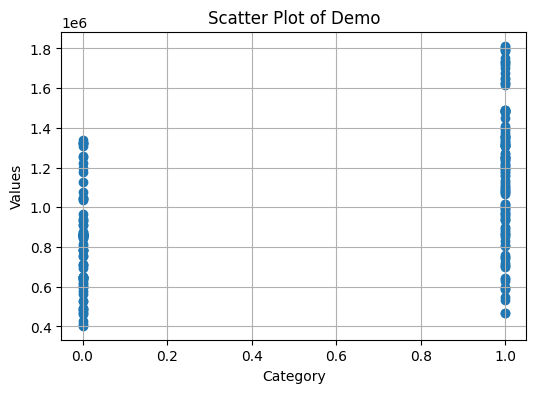

In [ ]:
import matplotlib.pyplot as plt
x, y = zip(*demo_rdd.collect())
plt.figure(figsize=(6, 4))
plt.scatter(x, y)
plt.title("Scatter Plot of Demo")
plt.xlabel("Category")
plt.ylabel("Values")
plt.grid(True)
plt.show()

Use mllib to train whole dataset

In [ ]:
from pyspark.ml.classification import LogisticRegression


lr = LogisticRegression(featuresCol='features', labelCol='ArrDel15')
model = lr.fit(train_data)
weights = model.coefficients
print("Model weights:", weights)


Model weights: [0.0,0.0,-0.0033742561274905914,0.12371163010248018,0.0006181299212311369,31.512983317966377,-0.015183889630008595,0.001664335858591569,0.008035126843138654,-0.01599011278460219,-2.2661338320088716e-05,1.7001857050702413e-05,-1.2839997274335633e-05,-3.6029123152644242,-0.015445573309413001,0.002888100489884004,-0.001362107508361331,0.029830977794675806,-52.5755404430278,-0.006414233881042344]


In [ ]:
test_rdd = test_data.rdd.map(lambda row: (row["features"].toArray(), row["ArrDel15"], predict(row["features"].toArray(), weights)))

In [ ]:
predictions_cf = test_rdd.map(lambda x: Row(features=Vectors.dense(x[0]), label=x[1], prediction=float(x[2]))).toDF()
predictions_cf = predictions_cf.select(col("prediction"), col("label").cast("double"))

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
precision = evaluator.evaluate(predictions_cf, {evaluator.metricName: "precisionByLabel"})
recall = evaluator.evaluate(predictions_cf, {evaluator.metricName: "recallByLabel"})
f1 = evaluator.evaluate(predictions_cf, {evaluator.metricName: "f1"})
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8234279094627988
Recall: 1.0
F1 Score: 0.7436910651236341
